In [1]:
import os
import sys
import pandas as pd
from functools import partial

In [2]:
sys.path.append("/home/rocassius/w266_final/scripts/assembly")
sys.path.append("/home/rocassius/w266_final/scripts/modeling")
sys.path

['/home/rocassius/w266_final/notebooks/exploratory/analysis',
 '',
 '/home/rocassius/anaconda3/lib/python3.7/site-packages',
 '/home/rocassius/anaconda3/lib/python37.zip',
 '/home/rocassius/anaconda3/lib/python3.7',
 '/home/rocassius/anaconda3/lib/python3.7/lib-dynload',
 '/home/rocassius/w266_final/scripts',
 '/home/rocassius/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/rocassius/.ipython',
 '/home/rocassius/w266_final/scripts/assembly',
 '/home/rocassius/w266_final/scripts/modeling']

In [3]:
# os.chdir("/home/rocassius/w266_final/scripts/assembly")
from constant import DOC_ALL_PATH
from document import *

In [4]:
# os.chdir("/home/rocassius/w266_final/scripts/modeling")
from rmn import *
from rmn_analyzer import *

In [5]:
df_all = load_documents(sessions=[99], read_path=DOC_ALL_PATH)

In [7]:
#==================#
#=*= RMN Module =*=#
#==================#

# RMN Class for training Relationship Modeling Networks 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Dense, Lambda, Input, Masking, Reshape
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.regularizers import Regularizer

from rmn_data_generator import RMN_DataGenerator
from helper import pickle_object, load_pickled_object
from vector_math import find_nn_cos

# constants
MAX_SPAN_LENGTH = 50
NUM_TOPICS = 20
LAMBDA = 5.0

# hyperparameters
OPTIMIZER = 'adam'
BATCH_SIZE = 50
EPOCHS = 5

# saving tags
RMN_TAG = "rmn_%s"
MODEL = "model.h5"
ATTR = "attributes"

# attribute keys
N_TOP_KEY = 'num_topics'
LAMB_KEY  = 'lambda'
EMBED_KEY = 'emedding_matrix'
TOKEN_KEY = 'tokenizer_dict'
META_KEY  = 'metadata_dict'


class RMN(object):
    """
    Class for constructing a Relationship Modeling Network
    """
    
    def __init__(self):
        
        # model parameters
        self.num_topics = NUM_TOPICS
        self.lamb = LAMBDA
        
        # model attrbiutes
        self.embedding_matrix = None
        self.tokenizer_dict = None
        self.metadata_dict = None
        
        # models 
        self.model = None
        self.topic_model = None
        
    
    @property
    def embedding_dim(self):
        return self.embedding_matrix.shape[1]
    
    
    def model_loss(self):
        """Hinge loss function.
        """
        def custom_loss(y_true, y_pred):
            # hinge_loss
            y_true_normalized = K.l2_normalize(y_true, axis=-1)
            y_pred_normalized = K.l2_normalize(y_pred, axis=-1)
            dot_product = K.sum(y_true_normalized * y_pred_normalized, axis=-1)
            hinge_loss = K.mean(K.maximum(0., 1. - dot_product))

            return hinge_loss 

        return custom_loss
    
    
    def build_model(self):
        """Connstruct the RMN model architecture
        """
        # document span input
        vt = Input(shape=(self.embedding_dim, ), name='Span.Input')
    
        input_layers = [vt]
        embedding_layers = [vt]
        
        for col in self.metadata_dict.keys():
            
            input_layer = Input(shape=(1,), name= col + '.Input')
            
            # embedding layer for col
            embedding_init = Embedding(
                input_dim = self.metadata_dict[col]['input_dim'] + 1, 
                output_dim = self.embedding_dim,
                input_length = 1)(input_layer)
            
            # reshape
            embedding_layer = Reshape((self.embedding_dim, ), name=col + '.Embed.Layer')(embedding_init)
            
            input_layers.append(input_layer)
            embedding_layers.append(embedding_layer)

        # concat speaker metadata embeddings
        _ht = tf.keras.layers.Concatenate(axis=1, name = 'Concat.Layer')(embedding_layers)

        # dense layer
        ht = Dense(units = self.embedding_dim, 
                   input_shape = (_ht.shape[1], ), 
                   activation = "relu", name = "Wh")(_ht)

        # dense layer with softmax activation, (where previous states will eventually be inserted) 
        dt = Dense(units = self.num_topics, 
                   input_shape = (self.embedding_dim, ), 
                   activation = "softmax", name = "Wd")(ht)

        # reconstruction layer
        rt = Dense(units = self.embedding_dim,
                   input_shape = (self.num_topics, ),
                   activation = "linear",
                   kernel_regularizer = Orthogonality(self.lamb),
                   name = "R")(dt)

        # compile
        model = tf.keras.Model(inputs=input_layers, outputs=rt)
        model.compile(optimizer = OPTIMIZER, loss = self.model_loss())
        self.model = model
        
        # build associated topic model
        self.build_topic_model()
    
    
    def build_topic_model(self, topic_layer = "Wd"):
        """Contruct model whose output is the topic distribution layer
        """
        topic_model = tf.keras.Model(
            inputs = self.model.input,
            outputs = self.model.get_layer(topic_layer).output)
        
        self.topic_model = topic_model
    
    def prep_y(self, y):
        """Returns the average of the vectors in each span of text
        """
        padded_spans = self.tokenizer_dict['tokenize_pad'](y)
        vector_spans = self.embedding_matrix[padded_spans].mean(axis=1)
        
        return vector_spans
    
    
    def prep_metadata(self, df):
        """Preps metadata for training or prediction
        """
        metadata_ids = [np.array(self.metadata_dict[col]['tokenize'](df[col]))
                        for col in self.metadata_dict.keys()]

        return metadata_ids
        
    
    def prep_inputs(self, df):
        """Preps metadata for training or prediction
        """
        vector_spans = self.prep_y(df['document'])
        metadata_ids = self.prep_metadata(df)
        inputs = [vector_spans] + metadata_ids
        
        return inputs
    
    
    def predict_topics(self, df):
        """Predicts the topic distributions for a df
        """
        
        # ensure the topic model has been built
        if self.topic_model is None:
            self.build_topic_model()
            
        topic_preds = self.topic_model.predict(x=self.prep_inputs(df))
        
        return topic_preds
    
    
    def predict_topics_generator(self, df):
        """Predict topic distributions with a generator
        """
        # Make sure data is not empty
        assert not df.empty

        # Calculate good batch size, 
        batch_size = max(1, min(10000, df.shape[0] // 10))
        n_batches = df.shape[0] // batch_size

        if n_batches < 2: 
            return self.predict_topics(df)
        else:
            # calculate remainder batch size
            r = df.shape[0] % batch_size

            if r == 0:
                g_index = df.index[:-batch_size]
                r_index = df.index[-batch_size:]
            else:
                g_index = df.index[:-r]
                r_index = df.index[-r:]

            # Make generator, predict on generator
            g = RMN_DataGenerator(self, df.loc[g_index], batch_size=batch_size, shuffle=False)

            # Predict on remainder batch
            r_pred = self.predict_topics(df.loc[r_index])
            g_pred = self.topic_model.predict_generator(
                g, use_multiprocessing=True, workers=10, verbose=1)

            assert r_pred.shape[1] == g_pred.shape[1]
            topic_preds = np.vstack([g_pred, r_pred])

            return topic_preds

    
    def fit(self, df, batch_size = BATCH_SIZE, epochs = EPOCHS):
        
        inputs = self.prep_inputs(df)
        y_true = self.prep_y(df['document'])
        
        self.model.fit(x = inputs, 
                       y = y_true, 
                       batch_size = batch_size, 
                       epochs = epochs)
    
    def save_rmn(self, name, save_path):
        """
        Save the model's weights, architecture and attributes
        """
        
        # assemble attribute dictionary
        attribute_dict = {
            N_TOP_KEY:  self.num_topics,
            LAMB_KEY:   self.lamb,
            EMBED_KEY:  self.embedding_matrix,
            TOKEN_KEY:  self.tokenizer_dict,
            META_KEY:   self.metadata_dict}
        
        # make directory for model
        model_path = os.path.join(save_path, RMN_TAG % name)
        os.mkdir(model_path)
        
        # save model weights
        self.model.save_weights(os.path.join(model_path, MODEL))
        
        # save model attributes
        pickle_object(attribute_dict, os.path.join(model_path, ATTR))
        
        
    def load_rmn(self, name, save_path):
        """
        Load the model, weights, architecture and attributes from a saved model
        """
        
        # make directory for model
        model_path = os.path.join(save_path, RMN_TAG % name)
        
        # load attributes
        attributes_dict = load_pickled_object(os.path.join(model_path, ATTR))
        
        # update attributes
        self.num_topics       = attributes_dict[N_TOP_KEY]
        self.lamb             = attributes_dict[LAMB_KEY]
        self.embedding_matrix = attributes_dict[EMBED_KEY]
        self.tokenizer_dict   = attributes_dict[TOKEN_KEY]
        self.metadata_dict    = attributes_dict[META_KEY]
        
        # construct identical model architecture
        self.build_model()
        
        # Load weights
        self.model.load_weights(os.path.join(model_path, MODEL))
        
        # build associated topic model
        self.build_topic_model()
        
    
    def inspect_topics(self, k_neighbors=10):
        """
        Ouput the nearest neighbors of every topic vector in
        the model's topic layer
        """
    
        # get embedding matrix, dim = [num_words, embedding_dim]
        E = self.embedding_matrix
        
        # get topic matrix, dim = [num_topics, embedding_dim]
        Wd = self.model.get_layer('Wd').get_weights()[0].T
        
        for i in range(Wd.shape[0]):
            
            neighbors, sim = find_nn_cos(Wd[i], E, k_neighbors)
            words = [self.tokenizer_dict['tokenizer'].index_word[v] for v in neighbors]
            
            print(20*"=" +"\n")
            print("Topic", i)
            print(words)
    
    
# Orthogonality Regularizer #

class Orthogonality(Regularizer):
    """Regularizer for discouraging non-orthogonal components.
    
    # Arguments
        lamb: Float; regularization penalty weight
    """

    def __init__(self, lamb = 1.):
        self.lamb = lamb

    def __call__(self, R):
        RRT = K.dot(R, K.transpose(R))
        I = K.eye(int(RRT.shape[0]))
        penalty = self.lamb * K.sqrt(K.sum(K.square(RRT - I)))
        
        return penalty

In [19]:
k = K.constant([[0.3, 0.3, 0,.4], [0.1, 0.1, 0,.8]])

In [16]:
K.maximum(K.constant([[0.3, 0.3, 0,.4], [0.1, 0.1, 0,.8]]))

TypeError: maximum() missing 1 required positional argument: 'y'

In [8]:
# make rmn
rmn_path="/home/rocassius/gen-data/models"
rmn_name="full"
rmn = RMN(); rmn.load_rmn(name=rmn_name, save_path=rmn_path)

In [9]:
df_samp = df_all.sample(400)

In [12]:
# analyzer = RMN_Analyzer(rmn, df_all)

In [13]:
# analyzer.predict_topics()

In [ ]:
# analyzer.predict_y()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import LogNorm

In [ ]:
def pca_plot(analyzer, conditions={}, sample_frac=0.1):
    cond_index = analyzer.cond_index(conditions).tolist()
    cond_df = analyzer.df.loc[cond_index]
    cond_topic_preds = analyzer.topic_preds[cond_index]
    party_labels = np.array(
        analyzer.rmn.metadata_dict[PARTY]['tokenize'](cond_df[PARTY])).flatten()
    
    
    pca = PCA()
    pc = pca.fit_transform(cond_topic_preds)
    
    # report
    print("cumulative explained variance to component 5")
    print(np.round(np.cumsum(pca.explained_variance_ratio_), 3)[:5])
    
    pc_data = pd.DataFrame({
        "pc0": pc[:,0], 
        "pc1": pc[:,1], 
        "party_label": party_labels
    }).sample(frac=sample_frac)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pc_data['pc0'], pc_data['pc1'], c = pc_data['party_label'], 
                cmap=matplotlib.colors.ListedColormap(['red', 'blue']), alpha = 0.1)
    

In [ ]:
# PCA projections for entire set of session 99 documents
pca_plot(analyzer, conditions={}, sample_frac=0.01)

In [ ]:
pca_plot(analyzer, conditions={SUB: 'abortion'}, sample_frac=1)

cumulative explained variance to component 5
[0.255 0.345 0.42  0.487 0.537]


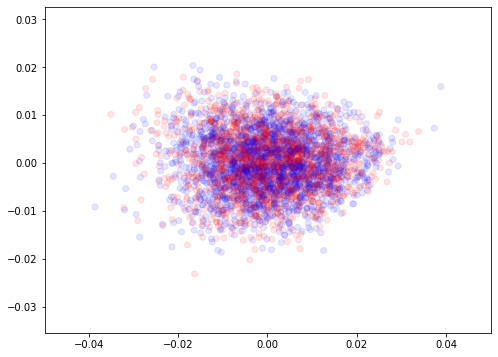

In [173]:
pca_plot(analyzer, conditions={SUB: 'money'}, sample_frac=0.5)

cumulative explained variance to component 5
[0.247 0.365 0.467 0.528 0.587]


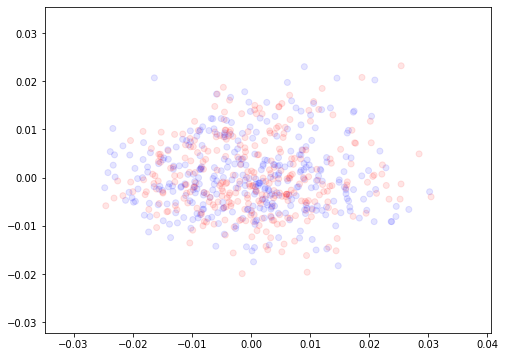

In [174]:
pca_plot(analyzer, conditions={SUB: 'alcohol'}, sample_frac=1)

cumulative explained variance to component 5
[0.22  0.329 0.413 0.484 0.541]


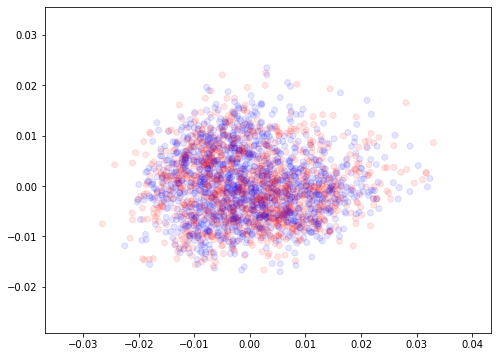

In [176]:
pca_plot(analyzer, conditions={SUB: 'crime'}, sample_frac=0.75)

cumulative explained variance to component 5
[0.222 0.311 0.386 0.456 0.515]


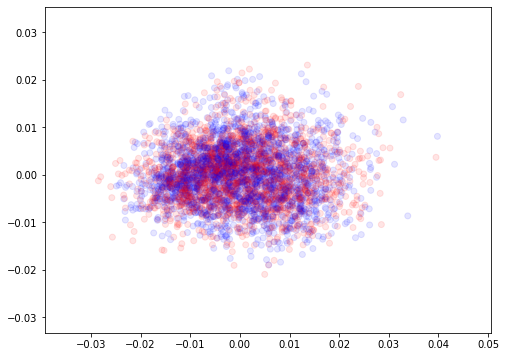

In [177]:
pca_plot(analyzer, conditions={SUB: 'drugs'}, sample_frac=1)

cumulative explained variance to component 5
[0.281 0.381 0.473 0.539 0.595]


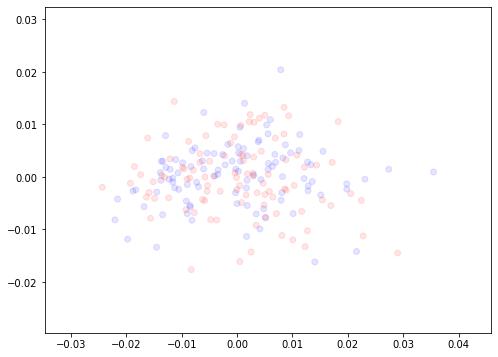

In [179]:
pca_plot(analyzer, conditions={SUB: 'women'}, sample_frac=1)

cumulative explained variance to component 5
[0.23  0.322 0.402 0.473 0.525]


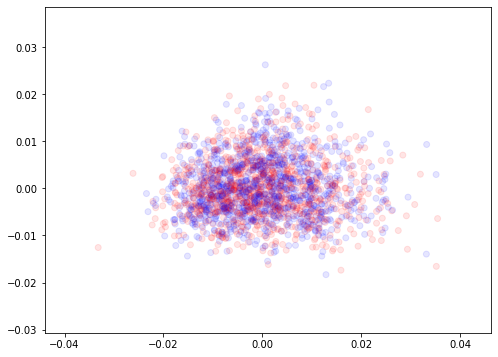

In [181]:
pca_plot(analyzer, conditions={SUB: 'defense'}, sample_frac=0.1)

Try a new session

In [182]:
df_111 = load_documents(sessions=[111], read_path=DOC_ALL_PATH)

In [184]:
analyzer2 = RMN_Analyzer(rmn, df_111)
analyzer2.predict_topics()

14/14 [==============================] - 8s 596ms/step


In [185]:
analyzer2.df["party_label"] = le.fit_transform(analyzer2.df["party"])

cumulative explained variance to component 5
[0.224 0.343 0.421 0.488 0.541]


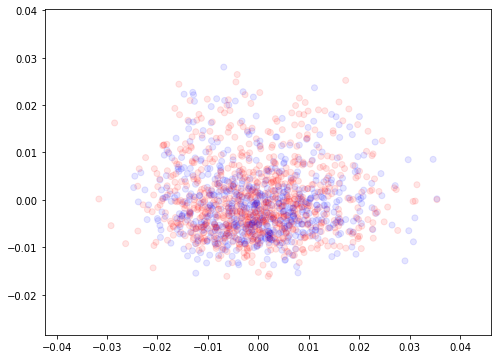

In [187]:
pca_plot(analyzer2, sample_frac=0.01)

cumulative explained variance to component 5
[0.284 0.443 0.512 0.574 0.626]


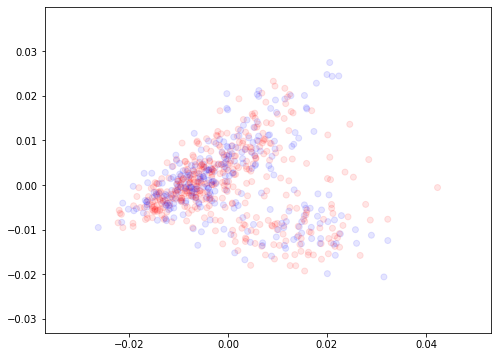

In [190]:
pca_plot(analyzer2, conditions={SUB: 'abortion'}, sample_frac=1)

cumulative explained variance to component 5
[0.203 0.322 0.395 0.465 0.523]


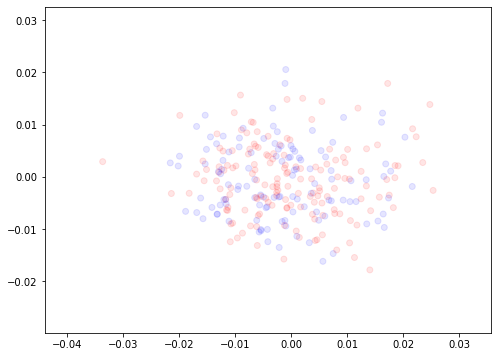

In [193]:
pca_plot(analyzer2, conditions={SUB: 'minorities'}, sample_frac=0.1)

In [266]:
analyzer.y_preds

array([[ 0.00293836,  0.00045459, -0.00275609, ...,  0.00093725,
        -0.00208569,  0.00341183],
       [ 0.00327649,  0.00132137,  0.00080716, ...,  0.00124351,
         0.00177742, -0.00096621],
       [ 0.00227792,  0.00246053, -0.00070804, ...,  0.00777434,
        -0.00041518,  0.00190366],
       ...,
       [ 0.00406467,  0.00306103, -0.00247703, ...,  0.0067178 ,
        -0.00420431, -0.00359862],
       [ 0.00400979,  0.00068113,  0.0024309 , ...,  0.00439277,
        -0.00058503,  0.00366895],
       [ 0.00428776,  0.00047629,  0.00412198, ...,  0.01004216,
        -0.00166792, -0.00018388]], dtype=float32)

In [267]:
def pca_y_plot(analyzer, conditions={}, sample_frac=0.1):
    cond_index = analyzer.cond_index(conditions).tolist()
    cond_df = analyzer.df.loc[cond_index]
    cond_y_preds = analyzer.y_preds[cond_index]
    party_labels = np.array(
        analyzer.rmn.metadata_dict[PARTY]['tokenize'](cond_df[PARTY])).flatten()
    
    pca = PCA()
    pc = pca.fit_transform(cond_y_preds)
    
    # report
    print("cumulative explained variance to component 5")
    print(np.round(np.cumsum(pca.explained_variance_ratio_), 3)[:5])
    
    pc_data = pd.DataFrame({
        "pc0": pc[:,0], 
        "pc1": pc[:,1], 
        "party_label": party_labels
    }).sample(frac=sample_frac)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pc_data['pc0'], pc_data['pc1'], c = pc_data['party_label'], 
                cmap=matplotlib.colors.ListedColormap(['red', 'blue']), alpha = 0.1)

cumulative explained variance to component 5
[0.224 0.32  0.397 0.472 0.529]


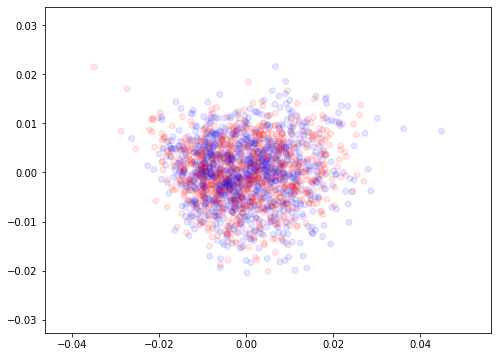

In [268]:
pca_y_plot(analyzer, sample_frac=0.01)

cumulative explained variance to component 5
[0.206 0.319 0.407 0.478 0.539]


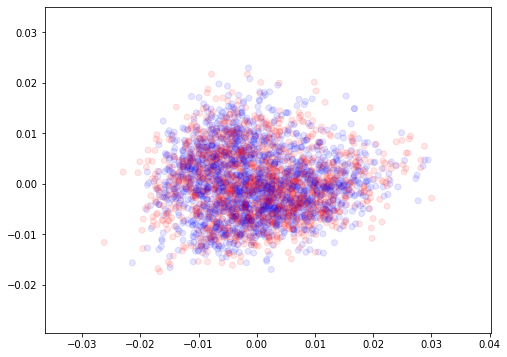

In [272]:
pca_y_plot(analyzer, conditions ={SUB: 'crime'}, sample_frac=1)

Find the nearest neighbors to PCA components 

In [319]:
def pca_y(analyzer, conditions={}, sample_frac=0.1):
    cond_index = analyzer.cond_index(conditions).tolist()
    cond_df = analyzer.df.loc[cond_index]
    cond_y_preds = analyzer.y_preds[cond_index]
    party_labels = np.array(
        analyzer.rmn.metadata_dict[PARTY]['tokenize'](cond_df[PARTY])).flatten()
    
    pca = PCA()
    pc = pca.fit_transform(cond_y_preds)
    
    # report
    print("cumulative explained variance to component 5")
    print(np.round(np.cumsum(pca.explained_variance_ratio_), 3)[:5])
    
    pc_data = pd.DataFrame({
        "pc0": pc[:,0], 
        "pc1": pc[:,1], 
        "party_label": party_labels
    }).sample(frac=sample_frac)
    
    return pca
    

In [320]:
E, Wd = analyzer.rmn.embedding_matrix, analyzer.rmn.topic_matrix

In [321]:
# abortion is a good example of 
# pca = pca_y(analyzer, conditions ={SUB: 'abortion'})
# pca = pca_y(analyzer, conditions ={SUB: 'education'})
pca = pca_y(analyzer, conditions ={SUB: 'defense'})

cumulative explained variance to component 5
[0.216 0.312 0.392 0.468 0.524]


In [322]:
pca.components_.shape

(50, 50)

In [323]:
C = pca.components_

In [324]:
from vector_math import find_nn_cos

In [325]:
k_neighbors = 5
top_n = 10

for i in range(top_n):

    neighbors, sim = find_nn_cos(C[i], E, k_neighbors)
    words = [analyzer.rmn.tokenizer_dict['tokenizer'].index_word[v] for v in neighbors]

    print(20*"=" +"\n")
    print("component", i)
    print(words)


/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: divide by zero encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))
/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: invalid value encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))



component 0
['costs', 'increase', 'reduce', 'cost', 'financing']

component 1
['liberation', 'exile', 'fought', 'exiled', 'war']

component 2
['graduated', 'ymca', 'college', 'bedford', 'school']

component 3
['chaired', 'nsc', 'ncc', 'pursuant', 'authorizes']

component 4
['silos', 'tankers', 'oilfields', 'ceyhan', 'lng']

component 5
['lire', 'pct', 'topping', 'ryutaro', 'kroner']

component 6
['convicts', 'paroled', 'apprehended', 'wrongfully', 'felons']

component 7
['answered', 'shoot', 'tape', 'landed', 'flip']

component 8
['preceding', 'monograph', 'seminal', 'predating', 'prologue']

component 9
['homestead', 'rename', 'electrify', 'enclose', 'traverse']
